<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [ ]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import output

%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d tommykamaz/faces-dataset-small

100% 3.98G/3.99G [01:00<00:00, 51.4MB/s]
100% 3.99G/3.99G [01:00<00:00, 70.4MB/s]


In [ ]:
!mkdir images
!unzip -q -o faces-dataset-small.zip -d images | awk 'BEGIN {ORS=" "} {if(NR%50==0)print "."}'

In [ ]:
DATA_DIR = './images/'

In [ ]:
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
from torchvision.transforms.transforms import ToTensor
def get_dataloader(image_size, batch_size):
    """
    Builds dataloader for training data.
    Use tt.Compose and tt.Resize for transformations
    :param image_size: height and width of the image
    :param batch_size: batch_size of the dataloader
    :returns: DataLoader object 
    """

    transform = tt.Compose([
        tt.Resize(image_size),
        tt.ToTensor(),
        tt.Normalize(*stats)
    ])
    data_folder = ImageFolder(
        root = DATA_DIR, 
        transform = transform
    )
    
    dataloader = DataLoader(data_folder, batch_size=batch_size, shuffle=True)
    return dataloader

In [ ]:
image_size = 64
batch_size = 128

dataloader = get_dataloader(image_size, batch_size)
#TODO: build dataloader and transfer it to device

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [ ]:
discriminator = nn.Sequential(
    # 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    nn.Sigmoid()
    # 1 x 1 x 1   
)

In [ ]:
latent_size = 128

generator = nn.Sequential(
    # latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size = 4, stride = 1, padding = 0, bias = False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # 3 x 64 x 64
)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
print(device)

cuda


In [ ]:
lr = 0.0002

model = {
    "discriminator": discriminator.to(device),
    "generator": generator.to(device)
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]
    
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach().cpu()[:nmax]), nrow=8).permute(1, 2, 0))

def show_image(image):
    plt.imshow(denorm(image.detach().cpu().permute(1, 2, 0)))

In [ ]:
len = 0
for X, _ in dataloader:
    len += X.shape[0]
len   

3143

In [ ]:
def fit(model, criterion, epochs, lr):

    model["discriminator"].train()
    model["generator"].train()

    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }

    dis_loss = []
    gen_loss = []
    for epoch in tqdm(range(epochs)):
        dis_cur_loss = 0
        gen_cur_loss = 0
        for X, y, in dataloader:
            X = X.to(device)
            # discriminator training
            optimizer["discriminator"].zero_grad()
            
            ## real
            pred = model["discriminator"](X).squeeze()
            true = torch.ones(X.shape[0]).to(device)
            real_loss = criterion["discriminator"](pred, true)
            dis_cur_loss += real_loss.item() / len

            ## generated
            latent = torch.randn(X.shape[0], latent_size, 1, 1).to(device)
            X_generated = model["generator"](latent)
            pred = model["discriminator"](X_generated).squeeze()
            true = torch.zeros(X.shape[0]).to(device)
            fake_loss = criterion["discriminator"](pred, true)
            dis_cur_loss += fake_loss.item() / len

            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()

            # generator training
            optimizer["generator"].zero_grad()
            
            latent = torch.randn(X.shape[0], latent_size, 1, 1).to(device)
            true = torch.ones(X.shape[0]).to(device)
            pred = model["discriminator"](model["generator"](latent)).squeeze()
            loss_g = criterion["generator"](pred, true)
            gen_cur_loss += loss_g.item() / len
            
            loss_g.backward()
            optimizer["generator"].step()

        output.clear()
        print(dis_cur_loss, gen_cur_loss)
        dis_loss.append(dis_cur_loss)
        gen_loss.append(gen_cur_loss)

        plt.figure(figsize=(30, 10))
        plt.subplot(1, 3, 1)
        plt.plot(dis_loss)
        plt.legend(['discriminator'])

        plt.subplot(1, 3, 2)
        plt.plot(gen_loss)
        plt.legend(['generator'])

        plt.subplot(1, 3, 3)
        latent = torch.randn(1, latent_size, 1, 1).to(device)
        show_image(model["generator"](latent).squeeze())

        plt.axis('off')
        plt.grid(visible=None)
        plt.show()


0.003334318314635409 0.030497316490340834


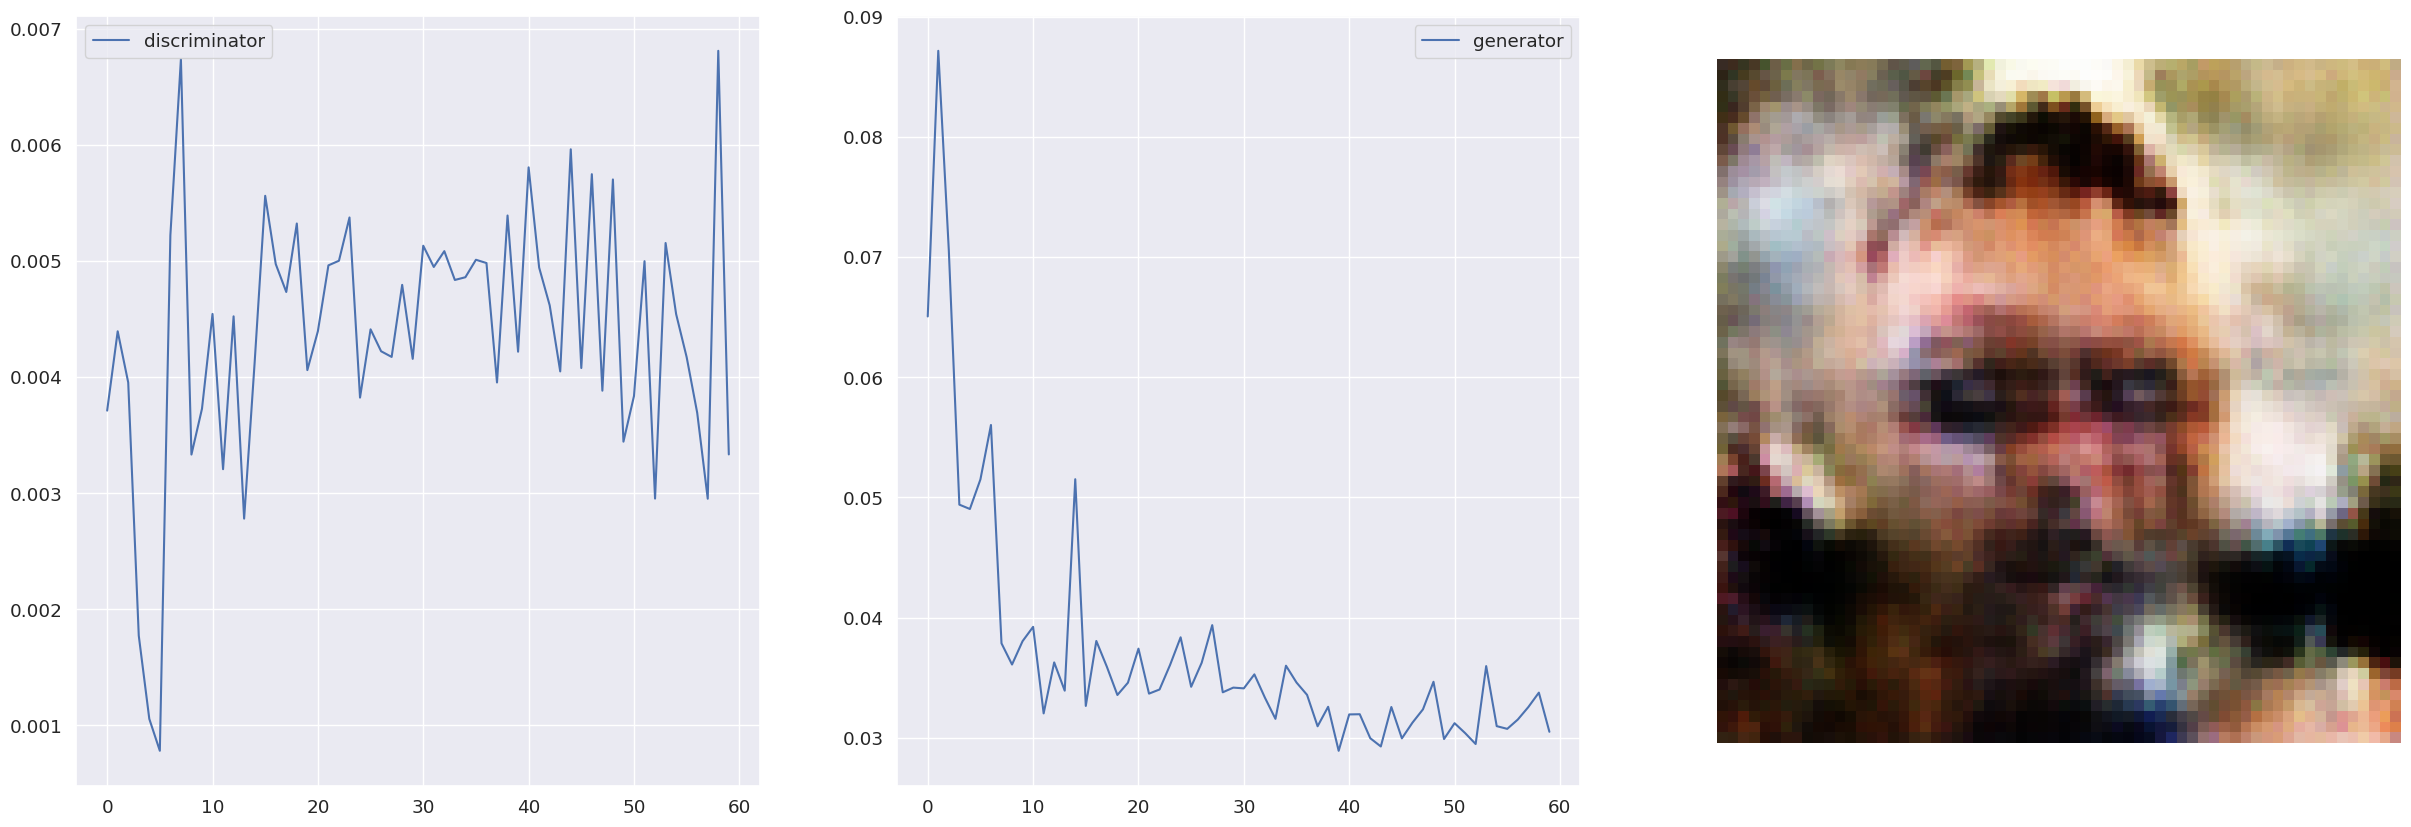

In [ ]:
fit(model, criterion, 60, 0.0002)

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [ ]:
n_images = 4

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

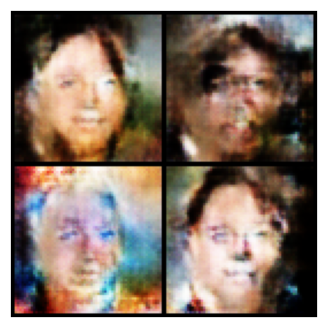

In [ ]:
def show_images(generated):
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(denorm(generated.detach().cpu()), nrow=2).permute(1, 2, 0))
show_images(fake_images)

Как вам качество получившихся изображений?

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [ ]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score

In [ ]:
X_test, y_test = None, None
is_first = False
for X, _ in dataloader:
    X = nn.Flatten()(X)
    y = torch.ones(X.shape[0])
    if is_first:
        X_test = pd.DataFrame(X.numpy())
        y_test = pd.DataFrame(y.numpy())
        is_first = False
    else:
        X_test = pd.concat([X_test, pd.DataFrame(X.numpy())])
        y_test = pd.concat([y_test, pd.DataFrame(y.numpy())])
     

In [ ]:
group = len // 64 # думаю ничего страшного если их будет на пару штук меньше

for i in tqdm(range(group)):
    fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)
    X = nn.Flatten()(model["generator"](fixed_latent)).detach().cpu()
    y = torch.zeros(X.shape[0])

    X_test = pd.concat([X_test, pd.DataFrame(X.numpy())])
    y_test = pd.concat([y_test, pd.DataFrame(y.numpy())])

  0%|          | 0/49 [00:00<?, ?it/s]

In [ ]:
X_df = X_test
y_df = y_test

In [ ]:
import warnings
warnings.filterwarnings('ignore')

loo = LeaveOneOut()
loo.get_n_splits(X_df)
sum, count = 0, 0
for train, test in tqdm(loo.split(X_df)):
    X_train, y_train = X_df.iloc[train, :], y_df.iloc[train, :]
    X_test, y_test = X_df.iloc[test, :], y_df.iloc[test, :]
    sum += accuracy_score(y_test, KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train).predict(X_test))
    count += 1

0it [00:00, ?it/s]

In [ ]:
accuracy = sum / count
accuracy

0.9213250517598344

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [ ]:
from sklearn.manifold import TSNE
X = TSNE(2).fit_transform(X_df)
     
y_df = y_df.to_numpy().squeeze()
     
y_df

array([1., 1., 1., ..., 0., 0., 0.], dtype=float32)

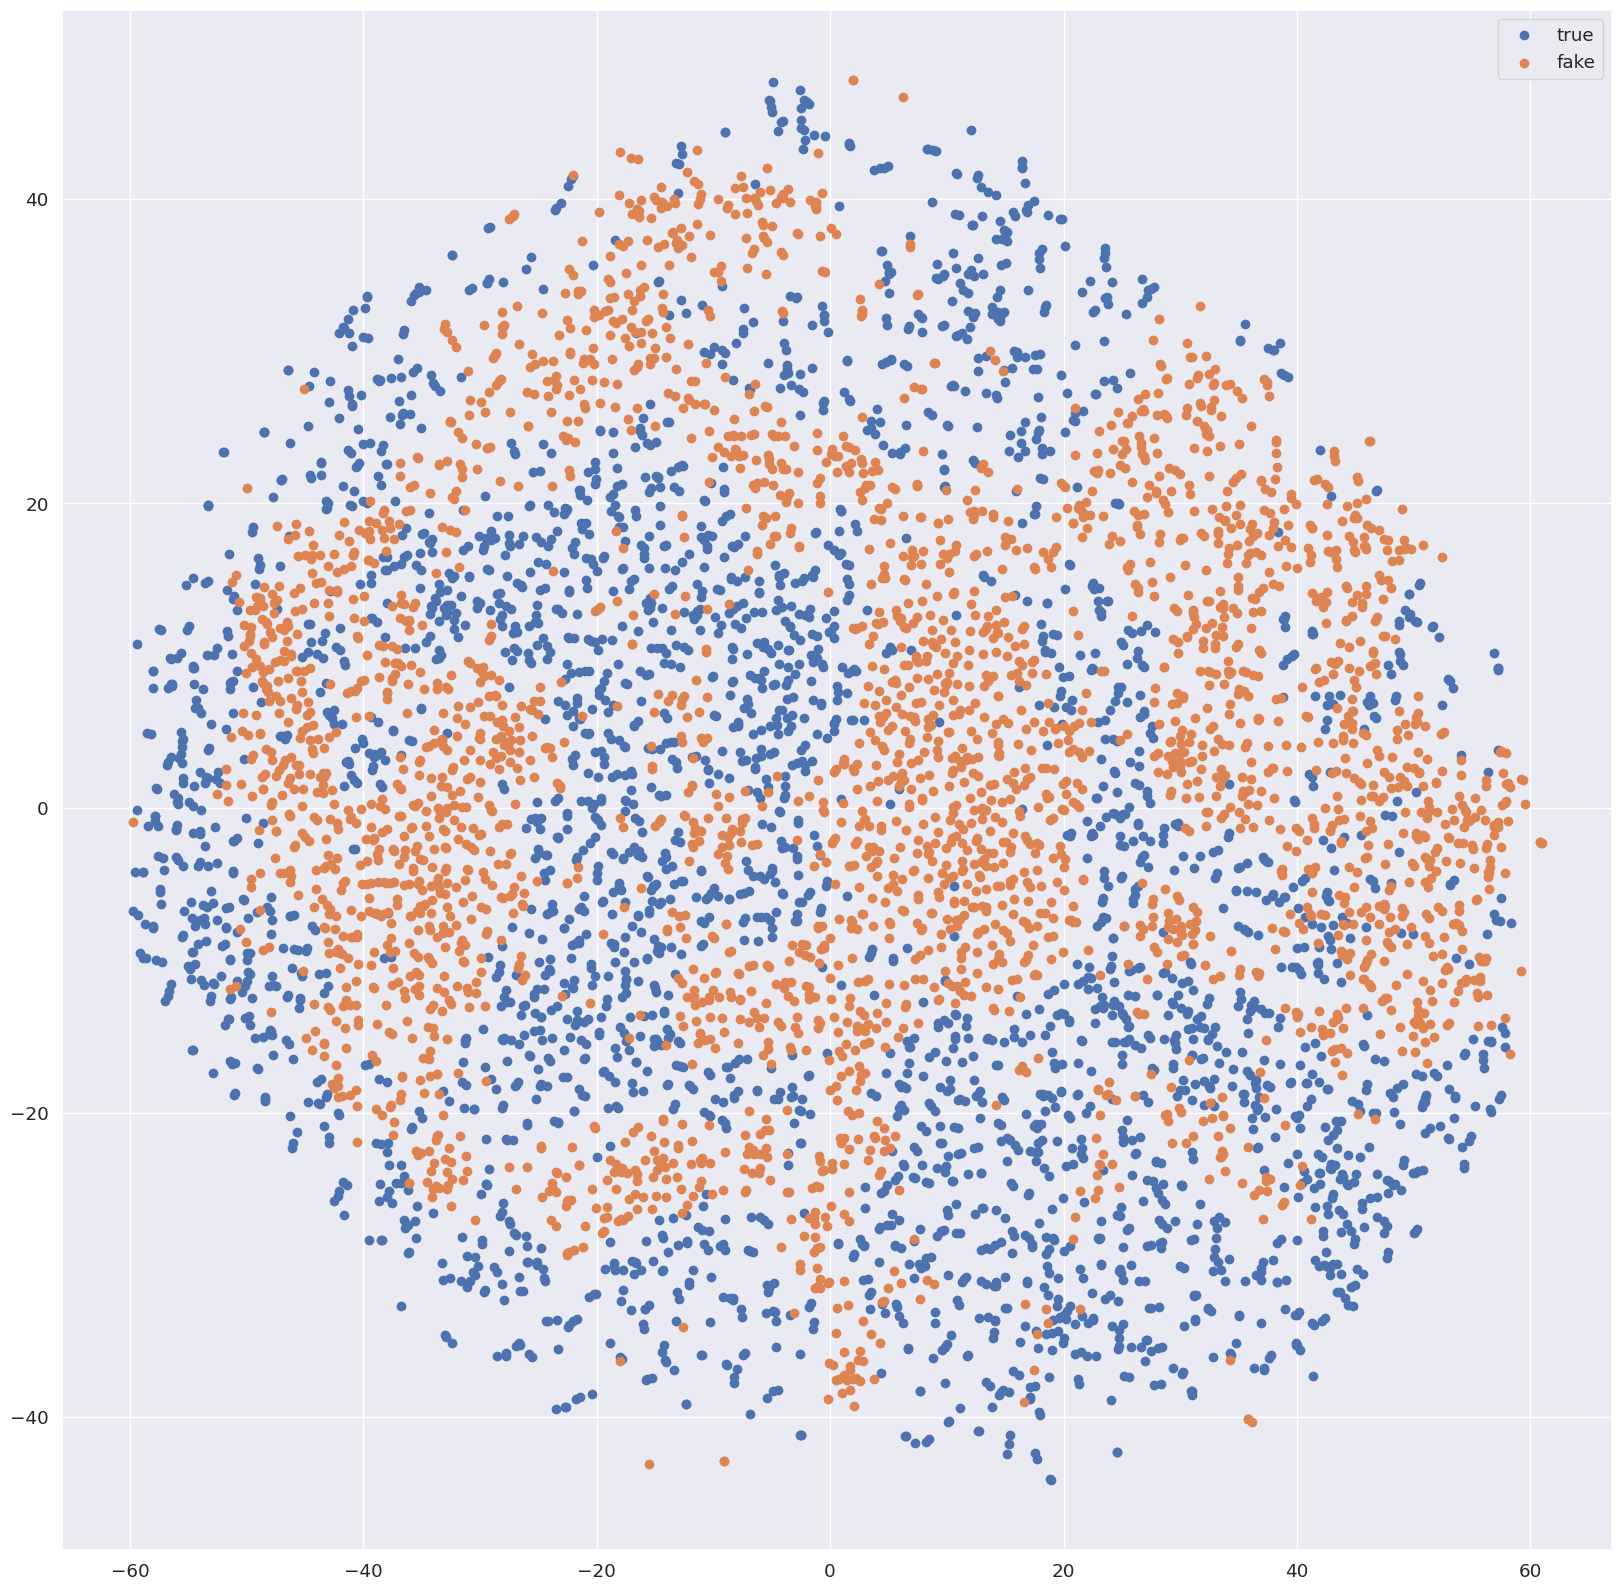

In [ ]:
import plotly.express as px
     
plt.figure(figsize=(20, 20))
plt.scatter(X[y_df == 0][:, 0], X[y_df == 0][:, 1])
plt.scatter(X[y_df == 1][:, 0], X[y_df == 1][:, 1])
plt.legend(['true', 'fake'])

Прокомментируйте получившийся результат: